In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from pmdarima import auto_arima

# We are going to use a very classic dataset called Mauna Loa Hawaii dataset
- Its the monthly average of Co2 levels in partsper million over a particular part in Hawaii.

In [6]:
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [7]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


- Now we are gonna see how we can use columns 'year' and 'month' and create a datetime index

In [13]:
#dict(year=df['year'],month=df['month'], day = 1);    #alternative way

df['date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

# We assumed that day starts at very first of thee month 

In [14]:
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
date            729 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.2 KB


- Lets set it as index

In [17]:
#df.set_index(df['date'])      #incomplete way
df = df.set_index('date')

In [18]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [19]:
df.index.freq='MS'

- Since the 'average' column misses some points, we are gonna use 'interpolated' column to plot 

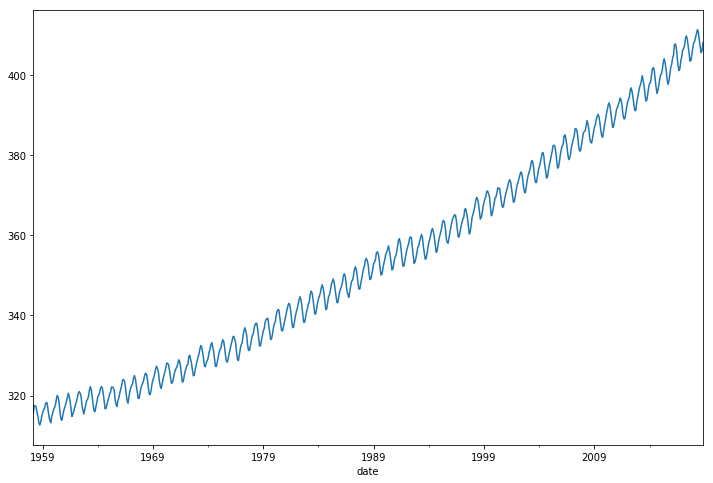

In [20]:
df['interpolated'].plot(figsize=(12,8)).autoscale(axis='x',tight=True)

- To confirm seasonality, we can do ets deconposition

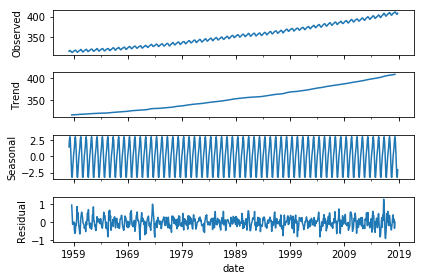

In [24]:
result = seasonal_decompose(df['interpolated'],model='add')
result.plot();

- Lets go ahead and run the auto_arima in order to obtain the recommended orders

In [26]:


auto_arima(df['interpolated'],seasonal=True,m=12).summary()

# We can choose m by plotting the seasonal part of the data and zoom in and see at what iterval the data is repeating

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -203.092
Date:                            Fri, 11 Jun 2021   AIC                            420.183
Time:                                    11:00:29   BIC                            452.315
Sample:                                         0   HQIC                           432.582
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.449      0.147      -0.000       0.002
ma.L1         -0.3577      0.037     -9.728      0.000      -0.430      -0.286
ma.L2         -0.0310      0.038     -0.813      0.416      -0.106       0.044
ma.L3         -0.0865      0.037     -2.349      0.019      -0.159      -0.014
ar.S.L12       0.9994      0.000   2999.488      0.000       0.999       1.000
ma.S.L12      -0.8695      0.021    -42.160      0.000      -0.910      -0.829
sigma2         0.0958      0.005     20.352      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       45.20   Jarque-Bera (JB):                 4.09
Prob(Q):                              0.26   Prob(JB):                         0.13
Heteroskedasticity (H):               1.11   Skew:                             0.01
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Now, lets go ahead and do train-test split on a data and test the test set and forecast

In [27]:
len(df)

729

- Lets go and set one year(12 months) for testing

In [28]:
train =df.iloc[:717]

In [29]:
test=df.iloc[717:]

In [30]:
# Create the model
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))

In [31]:
# Fit the model 
results = model.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -201.201
Date:                            Fri, 11 Jun 2021   AIC                            414.402
Time:                                    11:06:36   BIC                            441.845
Sample:                                03-01-1958   HQIC                           424.999
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3543      0.035    -10.200      0.000      -0.422      -0.286
ma.L2         -0.0244      0.038     -0.648      0.517      -0.098       0.050
ma.L3         -0.0866      0.032     -2.686      0.007      -0.150      -0.023
ar.S.L12       0.9997      0.000   3239.481      0.000       0.999       1.000
ma.S.L12      -0.8680      0.022    -38.921      0.000      -0.912      -0.824
sigma2         0.0949      0.005     20.315      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.96   Jarque-Bera (JB):                 4.45
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Lets go ahead and get our predicted values for our test set range 

In [33]:
start=len(train)

In [34]:
end=len(train)+len(test)-1

In [35]:
predictions=results.predict(start,end,typ='levels').rename('SARIMA Predictions')

# choose 'levels' here to make sure we dont have any issue of differencing components 

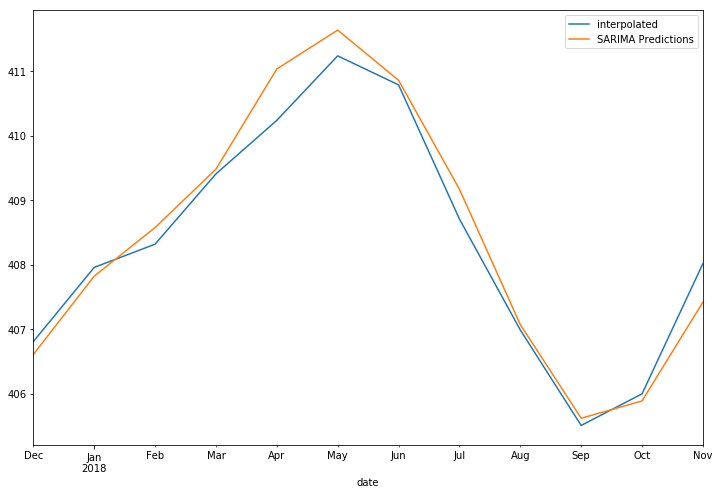

In [36]:
test['interpolated'].plot(legend=True,figsize=(12,8)).autoscale(axis='x',tight=True)
predictions.plot(legend=True).autoscale(axis='x',tight=True)

- We got pretty good results

- Now, if want to evaluate the model :::


In [37]:
from statsmodels.tools.eval_measures import rmse

In [38]:
error=rmse(test['interpolated'],predictions)

In [39]:
error

0.3573697479923076

- Thats our rmse error, and to check whether its good or bad::::::::

In [41]:
test['interpolated'].mean()

408.3333333333333

- looking at the mean() here, we can say that our error is so damn goood. 
- A rmse of ~100 would have been pretty bad for tis test result.

# Lets forecast into the future  

In [43]:
model =  SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results=model.fit()

In [44]:
fcast=results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA FORECAST')

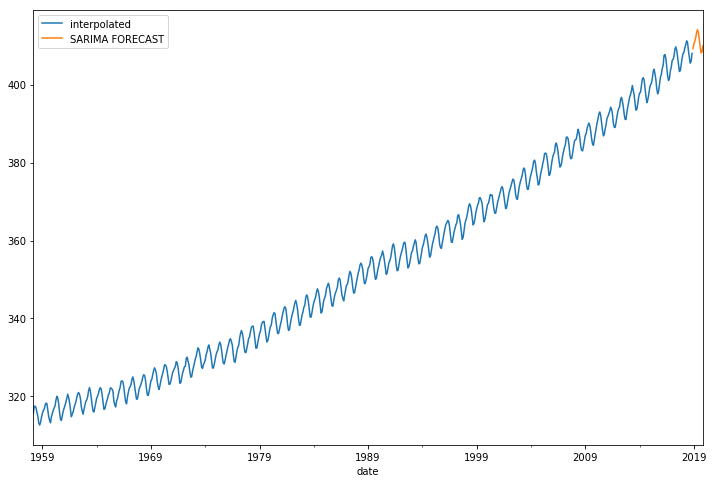

In [45]:
df['interpolated'].plot(legend=True, figsize=(12,8)).autoscale(axis='x',tight=True)
fcast.plot(legend=True).autoscale(axis='x',tight=True)